In [ ]:
!pip install rich

In [ ]:
import numpy as np
import pandas as pd
from pandas.core.dtypes.api import is_numeric_dtype, is_string_dtype, is_categorical_dtype
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
import graphviz, pickle

import os, pathlib, PIL, random, zipfile, cv2

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from mlxtend.plotting import plot_confusion_matrix
from yellowbrick.classifier import ClassificationReport, ClassPredictionError, ConfusionMatrix, ROCAUC

from scipy.stats import shapiro

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier

In [ ]:
from rich.console import Console
console = Console()

## **Loading data clean**

In [ ]:
df_music = pd.read_csv("https://storage.googleapis.com/questionsanswersproject/processed_music_data.csv")

df_music

,popularity,danceability,mode,valence,class,speechiness_log,acousticness_log,liveness_log,instrumentalness_log,duration_in_min_sg_log
0,60.0,0.854,1,0.8990,5,0.047361,0.016955,0.081488,0.003912,5.462118
1,54.0,0.382,1,0.5690,10,0.039797,0.001099,0.096219,0.004002,5.532334
2,35.0,0.434,1,0.7870,6,0.051168,0.396088,0.332177,0.000196,4.706526
3,66.0,0.853,0,0.5690,5,0.054015,0.020978,0.115113,0.003912,5.164603
4,53.0,0.167,1,0.0918,10,0.144468,0.000169,0.158712,0.015972,5.442245
...,...,...,...,...,...,...,...,...,...,...
17950,35.0,0.166,0,0.1770,6,0.040470,0.689641,0.093855,0.132285,5.270175
17951,27.0,0.638,0,0.3350,2,0.032370,0.619501,0.068126,0.000016,5.553219
17952,34.0,0.558,0,0.2620,8,0.068780,0.000030,0.404631,0.000136,5.380920
17953,29.0,0.215,0,0.3550,8,0.125751,0.001289,0.227932,0.132285,5.396773


In [ ]:
df_music.columns

Index(['popularity', 'danceability', 'mode', 'valence', 'class',
       'speechiness_log', 'acousticness_log', 'liveness_log',
       'instrumentalness_log', 'duration_in_min_sg_log'],
      dtype='object')

## **Division: Train and Test Sets**

In [ ]:
y = df_music["class"]
X = df_music.drop(columns=["class"])

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

In [ ]:
console.print(f"Original Dataset: {df_music.shape}")
console.print(f"X Training: {X_train.shape}, y Training: {y_train.shape}")
console.print(f"X Validation: {X_val.shape}, y Validation: {y_val.shape}")
console.print(f"X Test: {X_test.shape}, y test: {y_test.shape}")


console.print("\nDistribución de clases en el set original:")
console.print(y.value_counts(normalize=True))
console.print("\nDistribución de clases en el set de entrenamiento:")
console.print(y_train.value_counts(normalize=True))
console.print("\nDistribución de clases en el set de validación:")
console.print(y_val.value_counts(normalize=True))
console.print("\nDistribución de clases en el set de prueba:")
console.print(y_test.value_counts(normalize=True))

Original Dataset: (17955, 10)

X Training: (10773, 9), y Training: (10773,)

X Validation: (3591, 9), y Validation: (3591,)

X Test: (3591, 9), y test: (3591,)

Distribución de clases en el set original:

class
10    0.274520
6     0.143915
9     0.140407
8     0.102980
5     0.080479
1     0.076246
2     0.070621
0     0.034809
7     0.032080
3     0.022389
4     0.021554
Name: proportion, dtype: float64

Distribución de clases en el set de entrenamiento:

class
10    0.274483
6     0.143878
9     0.140444
8     0.102943
5     0.080479
1     0.076209
2     0.070547
0     0.034809
7     0.032117
3     0.022464
4     0.021628
Name: proportion, dtype: float64

Distribución de clases en el set de validación:

class
10    0.274575
6     0.143971
9     0.140351
8     0.103035
5     0.080479
1     0.076302
2     0.070732
0     0.034809
7     0.032025
3     0.022278
4     0.021442
Name: proportion, dtype: float64

Distribución de clases en el set de prueba:

class
10    0.274575
6     0.143971
9     0.140351
8     0.103035
5     0.080479
1     0.076302
2     0.070732
0     0.034809
7     0.032025
3     0.022278
4     0.021442
Name: proportion, dtype: float64

### **Apply SMOTE for training data**

Original dataset shape Counter({10: 2957, 6: 1550, 9: 1513, 8: 1109, 5: 867, 1: 821, 2: 760, 0: 375, 7: 346, 3: 
242, 4: 233})

Resampled dataset shape Counter({10: 2957, 6: 2957, 8: 2957, 1: 2957, 7: 2957, 2: 2957, 5: 2957, 3: 2957, 4: 2957, 
9: 2957, 0: 2957})

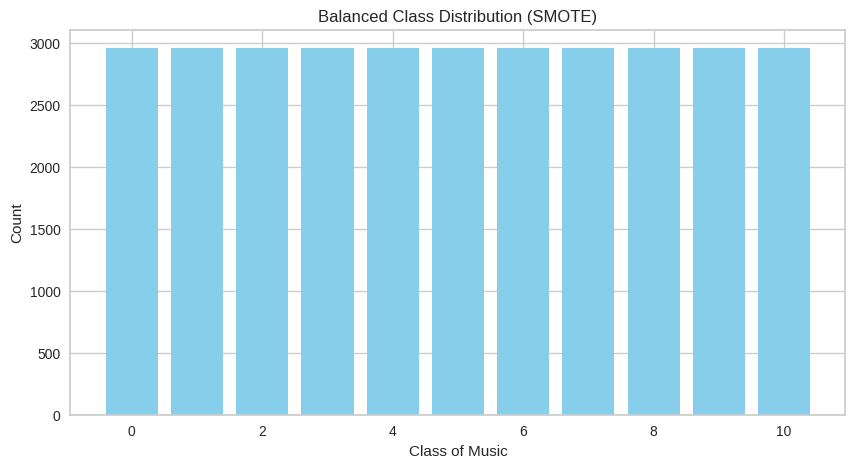

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X = X_train
y = y_train

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

console.print("Original dataset shape %s" % Counter(y))
console.print("Resampled dataset shape %s" % Counter(y_resampled))

# Create a new DataFrame with the resampled data
df_music_balanced = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='class')], axis=1)

# Visualize the balanced class distribution
class_balanced = df_music_balanced.groupby('class').size()
labels_balanced = class_balanced.index.values
sizes_balanced = class_balanced.values

plt.figure(figsize=(10, 5))
plt.bar(labels_balanced, sizes_balanced, color='skyblue')
plt.title('Balanced Class Distribution (SMOTE)')
plt.xlabel('Class of Music')
plt.ylabel('Count')
plt.show()

**SMOTE (Synthetic Minority Over-sampling Technique)** is an oversampling technique used in machine learning to address the problem of imbalanced datasets in classification problems.

**How Does SMOTE Work?**
Unlike simply duplicating existing minority class instances (which can lead to overfitting), SMOTE generates new synthetic samples of the minority class. It does this by following these steps:

- **Select a minority instance:** SMOTE randomly picks an instance from the minority class.
- **Identify nearest neighbors:** It finds the "k" nearest neighbors to that instance (typically 5 neighbors).
- **Generate synthetic samples:** One of these "k" neighbors is randomly chosen. A new synthetic point is then created on the line connecting the original minority class instance to the selected neighbor. This new point is placed at a random distance between them.

This process is repeated until the desired balance between classes is achieved. By generating new synthetic samples, SMOTE helps to expand the variety of minority class examples, allowing the model to learn more general patterns and reduce the risk of overfitting.



In [ ]:
X_train = X_resampled
y_train = y_resampled

console.print("Resampled dataset shape %s" % Counter(y_train))

Resampled dataset shape Counter({10: 2957, 6: 2957, 8: 2957, 1: 2957, 7: 2957, 2: 2957, 5: 2957, 3: 2957, 4: 2957, 
9: 2957, 0: 2957})

### **Standardization Variables**

In [ ]:
scaler = StandardScaler()

standar_model = scaler.fit(X_train)

X_train_scaled = standar_model.transform(X_train)
X_test_scaled = standar_model.transform(X_test)
X_val_scaled = standar_model.transform(X_val)
X_scaled = standar_model.transform(X)

X_train_stan_df = pd.DataFrame(X_train_scaled)
X_train_stan_df.columns = X_train.columns
X_train_stan_df.describe()

,popularity,danceability,mode,valence,speechiness_log,acousticness_log,liveness_log,instrumentalness_log,duration_in_min_sg_log
count,3.252700e+04,3.252700e+04,3.252700e+04,3.252700e+04,3.252700e+04,3.252700e+04,3.252700e+04,32527.000000,3.252700e+04
mean,1.310682e-16,3.285444e-16,6.990306e-17,-3.355347e-16,-5.592245e-17,-1.467964e-16,1.328158e-16,0.000000,1.698644e-15
std,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015,1.000015e+00
min,-2.411475e+00,-2.891562e+00,-1.386434e+00,-2.000685e+00,-1.085415e+00,-1.120164e+00,-1.681203e+00,-0.713941,-1.240792e+00
25%,-6.366548e-01,-6.417213e-01,-1.386434e+00,-7.845562e-01,-7.259756e-01,-9.922954e-01,-6.969928e-01,-0.686758,-1.240792e+00
50%,5.037225e-02,1.640882e-02,7.212749e-01,-5.858469e-03,-4.256472e-01,-2.595614e-01,-4.074778e-01,-0.637605,5.413553e-01
75%,6.801470e-01,6.613250e-01,7.212749e-01,7.809502e-01,3.955187e-01,9.983264e-01,5.051041e-01,0.661431,8.159875e-01
max,2.712602e+00,2.869443e+00,7.212749e-01,2.166904e+00,2.330272e+00,1.685524e+00,2.851192e+00,1.867807,1.392029e+00


**Select Standardization because:**

**Unknown or Non-Gaussian Distribution:** When the distribution of data is not known or does not follow a normal (Gaussian) pattern. For example in linear regression, we may want to normalize the dependent variable so it looks more like a bell curve, which allows for better confidence in our estimates.

## **Logistic Regression**

### Hyperparameter Selection

In [ ]:
from sklearn.linear_model import LogisticRegression

C_vals = np.logspace(-3, 2, 25)

f = make_subplots(1, 1, subplot_titles=['Balanced'])

r = [((m := LogisticRegression(C=c, random_state=42, solver='lbfgs', class_weight='balanced').fit(X_val_scaled, y_val)).score(X_val_scaled, y_val), m.score(X_test_scaled, y_test)) for c in C_vals]
f.add_trace(go.Scatter(x=C_vals, y=[t for t,_ in r], mode='lines', name=f'train_balanced'), 1, 1)
f.add_trace(go.Scatter(x=C_vals, y=[u for _,u in r], mode='lines', name=f'val_balanced'), 1, 1)

f.update_xaxes(type='log', title='C')
f.update_yaxes(title='Accuracy')
f.show()

We selected **C=10** since it gives good precision and it is seen to be maintained, and it is also seen that there is no overfitting since training and testing behave the same.

### Create and train logistic regression

In [ ]:
classification_log = LogisticRegression(C=10, solver='lbfgs', random_state=42)
classification_log.fit(X_train_scaled, y_train)

LogisticRegression(C=10, random_state=42)

### Test with training data

In [ ]:
y_pred_log_train = classification_log.predict(X_train_scaled)
console.print(classification_report(y_train, y_pred_log_train,zero_division=True))

precision    recall  f1-score   support

           0       0.65      0.70      0.68      2957
           1       0.31      0.09      0.14      2957
           2       0.50      0.63      0.56      2957
           3       0.79      0.75      0.77      2957
           4       0.74      0.81      0.77      2957
           5       0.68      0.78      0.73      2957
           6       0.37      0.27      0.31      2957
           7       0.91      0.94      0.92      2957
           8       0.55      0.76      0.64      2957
           9       0.39      0.37      0.38      2957
          10       0.27      0.29      0.28      2957

    accuracy                           0.58     32527
   macro avg       0.56      0.58      0.56     32527
weighted avg       0.56      0.58      0.56     32527

#### **1. Overall Performance**
- **Accuracy (58%)**: The model correctly classifies just over half of instances, indicating **moderate performance with room for improvement**.
- **Macro Avg (F1 = 0.56)**: Confirms the model struggles to generalize evenly across all classes.
- **Weighted Avg (F1 = 0.56)**: Similar to macro, showing problematic classes significantly impact performance.

#### **2. Class-Specific Insights**
- **Top Performers (F1 > 0.75)**:
  - **Class 7 (F1 = 0.92)**: Outstanding precision (0.91) and recall (0.94).
  - **Classes 3, 4, 5 (F1 = 0.77, 0.77, 0.73)**: Good precision-recall balance.
- **Moderate Performers (F1 0.5–0.7)**:
  - **Classes 0, 2, 8 (F1 = 0.68, 0.56, 0.64)**: Acceptable recall but low precision (especially Class 2).
- **Critical Underperformers (F1 < 0.4)**:
  - **Classes 1, 6, 9, 10 (F1 = 0.14, 0.31, 0.38, 0.28)**:
    - **Class 1 (Recall = 9%)**: Model barely detects instances of this class.
    - **Class 10 (Precision = 27%)**: High false positive rate.

#### **3. Key Issues Identified**
- **Class Imbalance**: Despite equal support (2957 per class), low recall in Classes 1/10 suggests model ignores/confuses them.
- **Precision-Recall Trade-offs**:
  - **Class 8 (Recall = 76%, Precision = 55%)**: Captures true instances but with many false positives.
  - **Class 6 (Precision = 37%, Recall = 27%)**: High both false positives and negatives.

### Test with test data

In [ ]:
y_pred_log_test = classification_log.predict(X_test_scaled)
console.print(classification_report(y_test, y_pred_log_test,zero_division=True))

precision    recall  f1-score   support

           0       0.63      0.58      0.60       125
           1       0.12      0.05      0.07       274
           2       0.27      0.56      0.37       254
           3       0.55      0.72      0.62        80
           4       0.44      0.81      0.57        77
           5       0.53      0.74      0.62       289
           6       0.37      0.23      0.28       517
           7       0.84      0.93      0.88       115
           8       0.40      0.73      0.52       370
           9       0.41      0.40      0.40       504
          10       0.49      0.29      0.36       986

    accuracy                           0.43      3591
   macro avg       0.46      0.55      0.48      3591
weighted avg       0.43      0.43      0.41      3591

Compared to the above, it is seen that in some like 1, 2, 3 the precision decreases and it is very reminiscent, which can lead to overfitting, however the overall precision is not so far from that of the training.

## **Decision Tree**

### Hyperparameter Selection

In [ ]:
hp = [('max_leaf_nodes',range(2, 50, 5)),('max_depth',(2, 7)),('min_samples_leaf',range(1, 50, 5))]
fig = make_subplots(1,3,subplot_titles=[n.replace('_',' ').title() for n,_ in hp])

for i,(param,vals) in enumerate(hp,1):
    stats=[(m:=DecisionTreeClassifier(random_state=42, class_weight='balanced')
             .set_params(**{param:v})
             .fit(X_val_scaled, y_val),
            m.score(X_val_scaled, y_val),
            m.score(X_test_scaled, y_test)) for v in vals]
    fig.add_trace(go.Scatter(x=list(vals), y=[t for _,t,_ in stats], mode='lines', name='train'), 1, i)
    fig.add_trace(go.Scatter(x=list(vals), y=[u for _,_,u in stats], mode='lines', name='test'),  1, i)

fig.show()

We selected **min_samples_leaf = 40** because it performs the best and is the point where less overfitting begins to occur.

### Create and train Decision Tree

In [ ]:
classification_tree = DecisionTreeClassifier(random_state=42, min_samples_leaf=40, class_weight='balanced').fit(X_train_scaled, y_train)

### Test with training data

In [ ]:
y_pred_dt_train = classification_tree.predict(X_train_scaled)
console.print(classification_report(y_train, y_pred_dt_train, zero_division=True))

precision    recall  f1-score   support

           0       0.74      0.81      0.78      2957
           1       0.46      0.48      0.47      2957
           2       0.61      0.70      0.65      2957
           3       0.85      0.83      0.84      2957
           4       0.84      0.86      0.85      2957
           5       0.73      0.77      0.75      2957
           6       0.43      0.38      0.40      2957
           7       0.94      0.92      0.93      2957
           8       0.68      0.75      0.72      2957
           9       0.52      0.50      0.51      2957
          10       0.46      0.33      0.38      2957

    accuracy                           0.67     32527
   macro avg       0.66      0.67      0.66     32527
weighted avg       0.66      0.67      0.66     32527

### Test with test data

The decision tree model reached 41% overall accuracy and a weighted F1-score of 0.40, indicating inconsistent performance among the musical genres.

Best performance:
Classes 7 and 5 achieved the highest F1-scores (87% and 60%, respectively), with high recall levels (91% and 70%), indicating good retrieval capability for these categories, though with lower precision in the case of Class 5 (52%).

Moderate performance:
Classes 3, 4, and 8 showed acceptable performance (F1 between 0.52 and 0.62), with reasonable recall but limited precision.

Poor performance:
Classes 1, 2, 6, and 10 had the lowest F1-scores (14% to 34%), reflecting the model's difficulty in correctly discriminating these genres. Notably, Class 10—despite having the highest number of samples—achieved an F1-score of just 0.32.

In [ ]:
y_pred_dt_test = classification_tree.predict(X_test_scaled)
console.print(classification_report(y_test, y_pred_dt_test, zero_division=True))

precision    recall  f1-score   support

           0       0.58      0.54      0.56       125
           1       0.12      0.16      0.14       274
           2       0.29      0.42      0.34       254
           3       0.54      0.72      0.62        80
           4       0.48      0.69      0.56        77
           5       0.52      0.70      0.60       289
           6       0.33      0.25      0.29       517
           7       0.83      0.91      0.87       115
           8       0.44      0.64      0.52       370
           9       0.43      0.42      0.42       504
          10       0.45      0.25      0.32       986

    accuracy                           0.41      3591
   macro avg       0.45      0.52      0.48      3591
weighted avg       0.41      0.41      0.40      3591

## **Support Vector Machine**

### Hyperparameter Selection

In [ ]:
from sklearn.svm import SVC

C_vals = np.logspace(-3, 2, 15)

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
titles = [f'{k or " - Balanced"}' for k in kernels]

f = make_subplots(rows=1, cols=4, subplot_titles=titles)


for c, k in enumerate(kernels, 1):
  res = [((m := SVC(kernel=k, C=cv, random_state=42, class_weight="balanced", verbose=1, tol=1e-4).fit(X_val_scaled, y_val)).score(X_val_scaled, y_val), m.score(X_test_scaled, y_test)) for cv in C_vals]
  f.add_trace(go.Scatter(x=C_vals, y=[t for t,_ in res], mode='lines', name=f'train_{k}_Balanced'), 1, c)
  f.add_trace(go.Scatter(x=C_vals, y=[u for _,u in res], mode='lines', name=f'val_{k}_Balanced'), 1, c)

f.update_xaxes(type='log', title='C')
f.update_yaxes(title='Accuracy')
f.update_layout(height=600, width=1100, showlegend=False)
f.show()

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

We selected **poly kernel and C=0.1** because it appears to have less overfitting and its accuracy is better.

### **Training**

In [ ]:
clf_svc = SVC(C=0.1, random_state=42, kernel='poly', class_weight='balanced')
clf_svc.fit(X_train_scaled, y_train)

SVC(C=0.1, class_weight='balanced', kernel='poly', random_state=42)

### Test with training data

In [ ]:
y_pred_svc_train = clf_svc.predict(X_train_scaled)
console.print(classification_report(y_train, y_pred_svc_train,zero_division=True))

precision    recall  f1-score   support

           0       0.68      0.85      0.76      2957
           1       0.33      0.45      0.38      2957
           2       0.53      0.67      0.59      2957
           3       0.90      0.77      0.83      2957
           4       0.78      0.82      0.80      2957
           5       0.76      0.76      0.76      2957
           6       0.45      0.23      0.31      2957
           7       0.95      0.94      0.94      2957
           8       0.65      0.69      0.67      2957
           9       0.46      0.44      0.45      2957
          10       0.37      0.24      0.29      2957

    accuracy                           0.62     32527
   macro avg       0.62      0.62      0.62     32527
weighted avg       0.62      0.62      0.62     32527

### Test with testing data

> Train vs. Test Comparison:
Train Accuracy (62%) vs. Test Accuracy (44%): A significant drop (~18 points) suggests overfitting. The model memorizes training-specific patterns but fails to generalize well to new data. F1-score (macro avg): Decreases from 0.62 (train) to 0.53 (test), further confirming overfitting.

- Classes with Strong Performance (F1 > 0.7 in test):

Class 7 (F1: 0.91): Excellent precision (88%) and recall (93%).

Class 3 (F1: 0.73): Good balance between precision (71%) and recall (75%).

- Classes with Moderate Performance (0.5 ≤ F1 ≤ 0.7):
Class 0 (F1: 0.68): Decent recall (73%), but precision could improve (65%).

Class 5 (F1: 0.63): High recall (72%) but moderate precision (57%).

Class 8 (F1: 0.55): Acceptable recall (64%) but low precision (49%).

- Classes with Poor Performance (F1 < 0.5):
Classes 1, 2, 6, 9, 10 (F1: 0.19–0.43): Critical issues, particularly in:

Class 1 (F1: 0.19): Low precision (14%) and recall (27%).

Class 10 (F1: 0.38): High sample count (986) but very low recall (28%).

In [ ]:
y_pred_svc_test = clf_svc.predict(X_test_scaled)
console.print(classification_report(y_test, y_pred_svc_test,zero_division=True))

precision    recall  f1-score   support

           0       0.65      0.73      0.68       125
           1       0.14      0.27      0.19       274
           2       0.30      0.57      0.39       254
           3       0.71      0.75      0.73        80
           4       0.47      0.83      0.60        77
           5       0.57      0.72      0.63       289
           6       0.42      0.24      0.30       517
           7       0.88      0.93      0.91       115
           8       0.49      0.64      0.55       370
           9       0.44      0.42      0.43       504
          10       0.56      0.28      0.38       986

    accuracy                           0.44      3591
   macro avg       0.51      0.58      0.53      3591
weighted avg       0.48      0.44      0.44      3591

## **RandomForest**

This experiment evaluates a Random Forest classifier using randomized hyperparameter search to optimize model performance. The proposed parameter grid (`param_grid_rf`) explores key configurations:

Tree complexity: `max_depth` (5–30),` min_samples_split` (2–20), and `min_samples_leaf` (1–20).

Ensemble size: `n_estimators` (50–300).

Feature selection: `max_features` options (None, sqrt, log2).

In [ ]:
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

param_grid_rf = {
    "n_estimators": randint(50, 300),
    "max_depth": [None] + list(range(5, 30)),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 20),
    "max_features": [None, "sqrt", "log2"]
}

In [ ]:
random_forest_classifier = RandomForestClassifier(random_state=90)

This configuration uses RandomizedSearchCV to explore the set of hyperparameters for the Random Forest classifier, aiming to maximize accuracy measure.

In [ ]:
random_search_rf = RandomizedSearchCV(
    estimator = random_forest_classifier,
    param_distributions = param_grid_rf,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

In [ ]:
random_search_rf.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=90),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 5, 6, 7, 8, 9, 10,
                                                      11, 12, 13, 14, 15, 16,
                                                      17, 18, 19, 20, 21, 22,
                                                      23, 24, 25, 26, 27, 28,
                                                      29],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fa415565290>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fa415566510>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fa41537c790>},
                   random_state=42, scoring='accuracy')

In [ ]:
# Print the best parameters and best score
console.print("Best parameters found: ", random_search_rf.best_params_)
console.print("Best accuracy found: ", random_search_rf.best_score_)

Best parameters found: 
{'max_depth': 23, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 100}

Best accuracy found:  0.7417860271119687

In [ ]:
random_forest_classifier_best_model = random_search_rf.best_estimator_

In [ ]:
console.print(f'Exactitud RF: {random_forest_classifier_best_model.score(X_test_scaled, y_test) * 100} %')

Exactitud RF: 43.636869952659424 %

In [ ]:
scores = cross_val_score(estimator = random_forest_classifier,
                         X = X_scaled,
                         y = y,
                         cv = 4,
                         scoring='accuracy',
                         n_jobs=-1)

console.print(f'Exactitud CV RF: {scores}')
console.print(f'Exactitud CV RF: {np.mean(scores):.3f}' f' +/- {np.std(scores):.3f}')

Exactitud CV RF: [0.4840386  0.48310434 0.49164501 0.48570368]

Exactitud CV RF: 0.486 +/- 0.003

In [ ]:
scores = cross_val_score(estimator = random_forest_classifier_best_model,
                         X = X_scaled,
                         y = y,
                         cv = 4,
                         scoring='accuracy',
                         n_jobs=-1)

console.print(f'Exactitud CV RF: {scores}')
console.print(f'Exactitud CV RF: {np.mean(scores):.3f}' f' +/- {np.std(scores):.3f}')

Exactitud CV RF: [0.49331849 0.48310434 0.494987   0.48384701]

Exactitud CV RF: 0.489 +/- 0.005

Though, the Randimized search CV found a set of hiperparameters to max accuracy, We realized that this model and a default configuration (`min_samples_split` =2, `min_samples_leaf` =1, `n_estimators` =100) reach almost the same results.

### Test with training data

In [ ]:
y_pred_random_forest_train = random_forest_classifier_best_model.predict(X_train_scaled)
console.print(classification_report(y_train, y_pred_random_forest_train, zero_division=True))

precision    recall  f1-score   support

           0       0.98      0.99      0.98      2957
           1       0.92      0.92      0.92      2957
           2       0.96      0.98      0.97      2957
           3       0.99      0.99      0.99      2957
           4       0.98      0.99      0.99      2957
           5       0.93      0.98      0.96      2957
           6       0.93      0.88      0.91      2957
           7       0.99      1.00      1.00      2957
           8       0.94      0.97      0.96      2957
           9       0.94      0.91      0.93      2957
          10       0.90      0.85      0.88      2957

    accuracy                           0.95     32527
   macro avg       0.95      0.95      0.95     32527
weighted avg       0.95      0.95      0.95     32527

### Test with testing data

In [ ]:
y_pred_random_forest_test = random_forest_classifier_best_model.predict(X_test_scaled)
console.print(classification_report(y_test, y_pred_random_forest_test, zero_division=True))

precision    recall  f1-score   support

           0       0.61      0.69      0.65       125
           1       0.08      0.08      0.08       274
           2       0.33      0.42      0.37       254
           3       0.68      0.71      0.70        80
           4       0.54      0.70      0.61        77
           5       0.59      0.73      0.65       289
           6       0.31      0.27      0.29       517
           7       0.87      0.92      0.89       115
           8       0.51      0.62      0.56       370
           9       0.48      0.46      0.47       504
          10       0.41      0.32      0.36       986

    accuracy                           0.44      3591
   macro avg       0.49      0.54      0.51      3591
weighted avg       0.43      0.44      0.43      3591

1. Train vs. Test Performance:  A huge and visual Discrepancy between two performances.

>Training Metrics (Suspiciously High):

Accuracy: 95%

F1-scores: 0.88–1.00 across all classes

Near-perfect recall/precision (e.g., Class 7: 1.00 F1).

> Test Metrics (Poor Generalization):

Accuracy drops to 44% (51% gap from training).

F1-scores collapse (e.g., Class 1: 0.08, Class 10: 0.36).

Macro F1 falls from 0.95 (train) to 0.51 (test).

## **XGBoost**

Now, we experiment leverages XGBoost (eXtreme Gradient Boosting) to address the critical limitations observed in previous models—specifically, the severe overfitting of the Random Forest classifier and its inability to generalize to unseen data.

In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xgb
from scipy.stats import uniform, randint

param_grid_xgb = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 0.5),
    'reg_lambda': uniform(1, 0.5)
}


In [ ]:
num_classes = len(np.unique(y))

In [ ]:
# Initialize XGBoost classifier
# Using use_label_encoder=False and eval_metric='mlogloss' for multi-class classification
# Setting objective to 'multi:softmax' for multi-class prediction
# Adjusting scale_pos_weight might be needed if data is highly imbalanced after SMOTE, but SMOTE already balanced the training set, so we might not need it here.
xgb_classifier = xgb.XGBClassifier(objective='multi:softmax',
                                   use_label_encoder=False,
                                   eval_metric='mlogloss',
                                   num_class=num_classes,
                                   random_state=42)

As we saw, here we again use RandomizedSearchCV  passing in a set of hiperparameters to evaluate the accuracy and select the best modelo in this approach. Its used 10 interations and 5 folds.

In [ ]:
]random_search_xgb = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_grid_xgb,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search_xgb.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[22:31:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b57efffdb50>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b57f42887d0>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b57efed8390>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b57fe3e4790>},
                   random_state=42, scoring='accuracy', verbose=1)

In [ ]:
console.print("Best parameters found: ", random_search_xgb.best_params_)
console.print("Best accuracy found: ", random_search_xgb.best_score_)

xgb_classifier_best_model = random_search_xgb.best_estimator_

Best parameters found: 
{
    'colsample_bytree': np.float64(0.9579309401710595),
    'gamma': np.float64(0.29894998940554257),
    'learning_rate': np.float64(0.28656227050693506),
    'max_depth': 8,
    'min_child_weight': 7,
    'n_estimators': 298,
    'reg_alpha': np.float64(0.48058601217467456),
    'reg_lambda': np.float64(1.4222669243390758),
    'subsample': np.float64(0.8989280440549523)
}

Best accuracy found:  0.7566974776195473

In [ ]:
console.print(f'Accuracy xgb: {xgb_classifier_best_model.score(X_test_scaled, y_test) * 100} %')

Exactitud xgb: 45.27986633249791 %

In [ ]:
scores_xgb_cv = cross_val_score(estimator=xgb_classifier_best_model,
                              X=X_scaled,
                              y=y,
                              cv=4,
                              scoring='accuracy',
                              n_jobs=-1)

console.print(f'Accuracy CV XGBoost (on full dataset with best model): {scores_xgb_cv}')
console.print(f'Accuracy CV XGBoost (on full dataset with best model): {np.mean(scores_xgb_cv):.3f}' f' +/- {np.std(scores_xgb_cv):.3f}')

Exactitud CV XGBoost (on full dataset with best model): [0.46585004 0.46973635 0.47419235 0.46602302]

Exactitud CV XGBoost (on full dataset with best model): 0.469 +/- 0.003

### Test with training data

In [ ]:
y_pred_xgb_train = xgb_classifier_best_model.predict(X_train_scaled)
console.print(classification_report(y_train, y_pred_xgb_train, zero_division=True))

precision    recall  f1-score   support

           0       0.99      0.99      0.99      2957
           1       0.92      0.94      0.93      2957
           2       0.98      0.99      0.98      2957
           3       1.00      1.00      1.00      2957
           4       0.99      1.00      0.99      2957
           5       0.97      0.99      0.98      2957
           6       0.95      0.89      0.92      2957
           7       1.00      1.00      1.00      2957
           8       0.96      0.99      0.97      2957
           9       0.96      0.95      0.95      2957
          10       0.92      0.88      0.90      2957

    accuracy                           0.97     32527
   macro avg       0.97      0.97      0.97     32527
weighted avg       0.97      0.97      0.97     32527

### Test with testing data

1. Train vs. Test Performance: A huge and visual Discrepancy between two performances.

> Training Metrics (Suspiciously High):

Accuracy: 97% (near-perfect)

F1-scores: 0.90–1.00 across all classes

Classes 3, 4, 7 achieve 1.00 F1 (potential memorization).

> Test Metrics: Poor Generalization

Accuracy drops to 45% (52% gap from training).

F1-scores collapse (e.g., Class 1: 0.10, Class 6: 0.29, Class 10: 0.41).

Macro F1 falls from 0.97 (train) to 0.53 (test).

Diagnosis: Severe overfitting—despite regularization, the model fails to generalize.

In [ ]:
y_pred_xgb_test = xgb_classifier_best_model.predict(X_test_scaled)
console.print(classification_report(y_test, y_pred_xgb_test, zero_division=True))

precision    recall  f1-score   support

           0       0.74      0.69      0.71       125
           1       0.10      0.10      0.10       274
           2       0.34      0.37      0.35       254
           3       0.67      0.76      0.71        80
           4       0.55      0.70      0.62        77
           5       0.60      0.71      0.65       289
           6       0.30      0.27      0.29       517
           7       0.88      0.92      0.90       115
           8       0.54      0.59      0.57       370
           9       0.50      0.48      0.49       504
          10       0.43      0.39      0.41       986

    accuracy                           0.45      3591
   macro avg       0.51      0.55      0.53      3591
weighted avg       0.45      0.45      0.45      3591

## **Performance Comparison**

In [ ]:
Clases = df_music.groupby('class').size()
classes, classifiers = list(Clases.index), [classification_log, classification_tree, clf_svc, random_forest_classifier_best_model, xgb_classifier_best_model]
console.print(classes)
console.print(classifiers)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

[
    LogisticRegression(C=10, random_state=42),
    DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=40,
                       random_state=42),
    SVC(C=0.1, class_weight='balanced', kernel='poly', random_state=42),
    RandomForestClassifier(max_depth=23, max_features=None, min_samples_leaf=3,
                       min_samples_split=6, random_state=90),
    XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.9579309401710595), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=np.float64(0.29894998940554257), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.28656227050693506), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=298, n_jobs=None, num_class=11,
              num_parallel_tree=None, ...)
]

### **Report**

### **Testing Dataset**

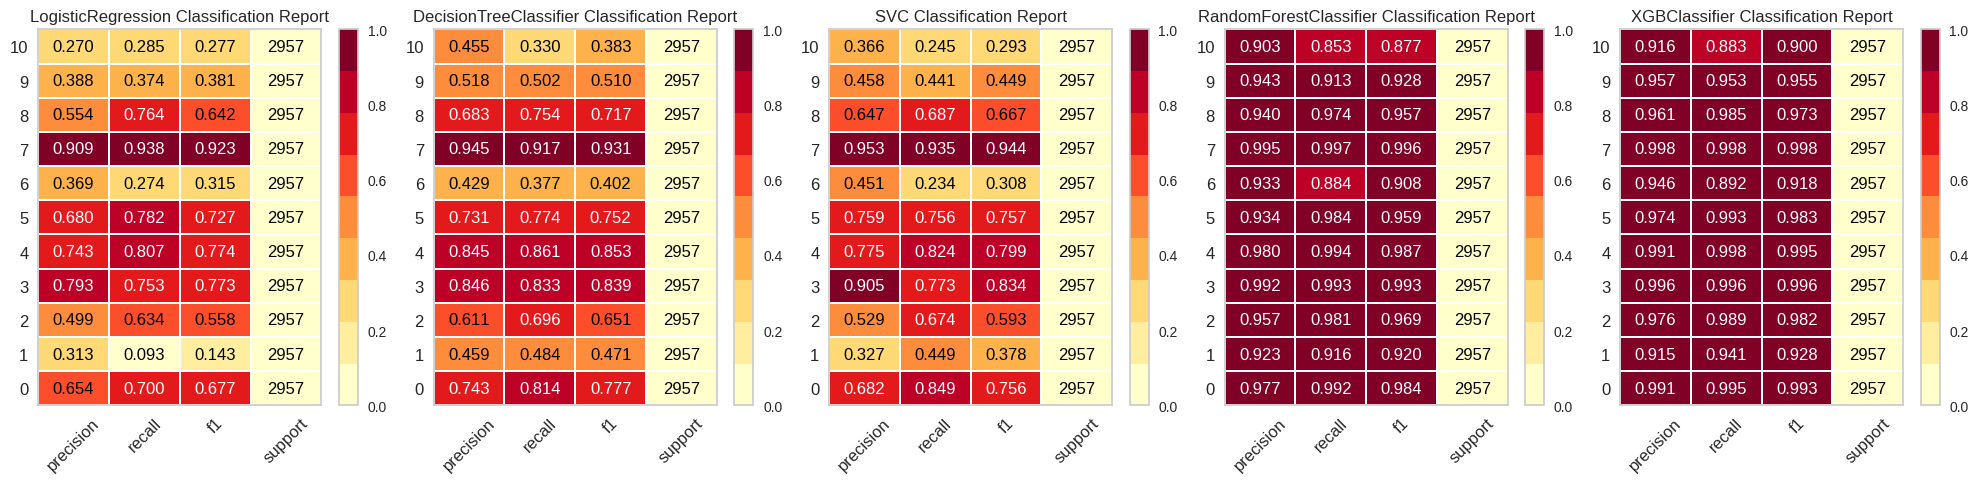

In [ ]:
fig, axe = plt.subplots(ncols=5,nrows=1,figsize=(20, 5))
fig.tight_layout(pad=8.0)
visualgrid = [ClassificationReport(classifiers[0], classes=classes, support=True,ax=axe[0]),
              ClassificationReport(classifiers[1], classes=classes, support=True,ax=axe[1]),
              ClassificationReport(classifiers[2], classes=classes, support=True,ax=axe[2]),
              ClassificationReport(classifiers[3], classes=classes, support=True,ax=axe[3]),
              ClassificationReport(classifiers[4], classes=classes, support=True,ax=axe[4]),]
for viz in visualgrid:
  viz.fit(X_train_scaled, y_train)
  viz.score(X_train_scaled, y_train)
  viz.finalize()
fig.show()

### **Test Dataset**

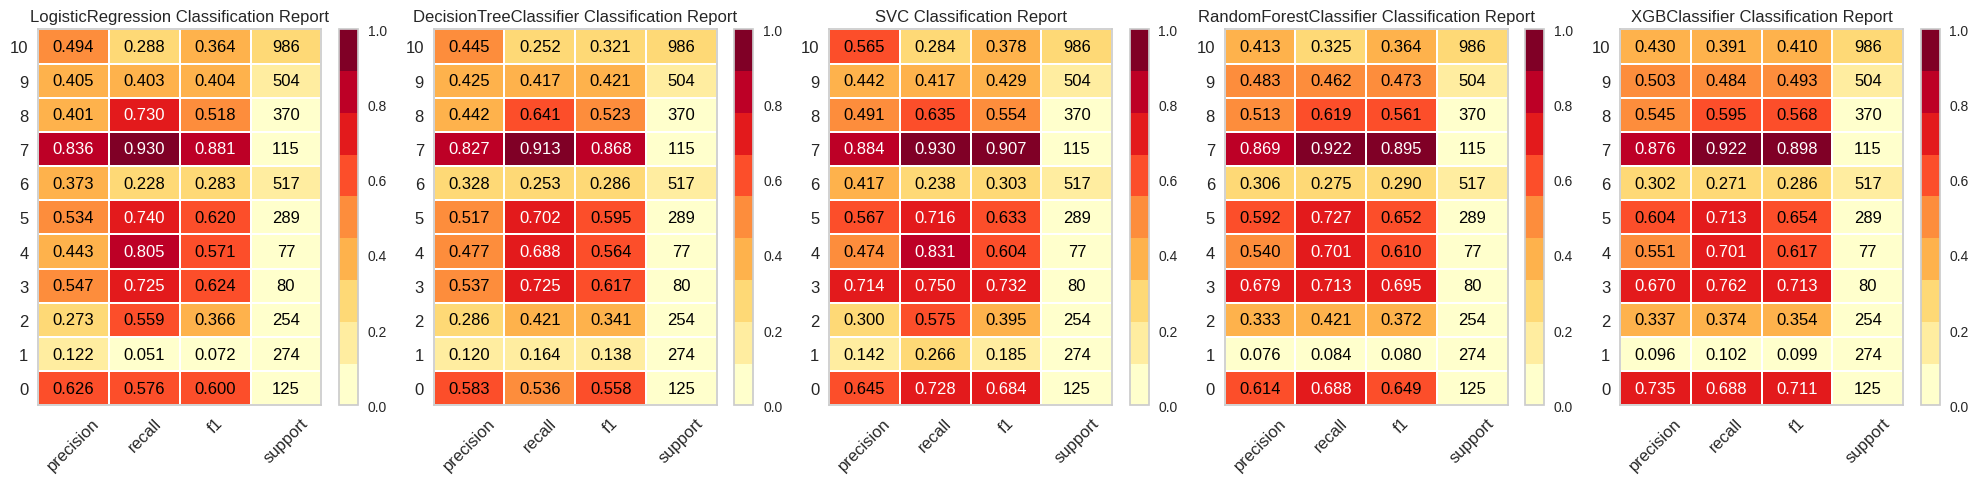

In [ ]:
fig, axe = plt.subplots(ncols=5,nrows=1,figsize=(20, 5))
fig.tight_layout(pad=8.0)

visualgrid = [ClassificationReport(classifiers[0], classes=classes, support=True,ax=axe[0]),
              ClassificationReport(classifiers[1], classes=classes, support=True,ax=axe[1]),
              ClassificationReport(classifiers[2], classes=classes, support=True,ax=axe[2]),
              ClassificationReport(classifiers[3], classes=classes, support=True,ax=axe[3]),
              ClassificationReport(classifiers[4], classes=classes, support=True,ax=axe[4]),]

for viz in visualgrid:
  viz.fit(X_test_scaled, y_test)
  viz.score(X_test_scaled, y_test)
  viz.finalize()
fig.show()

> 1. **Overall Observations**

- Class 7 consistently achieves high F1-scores (≥ 0.86) across all models, indicating it's well learned by all classifiers.

- Class 1 is problematic for all models, with F1-scores below 0.14, reflecting poor performance due to likely class imbalance or low feature separability.

- Logistic Regression, Random Forest, and XGBoost show more balanced performance across multiple classes, while Decision Tree and SVC show greater variance.

> 2. **Model Comparison**

**Logistic Regression**

High recall for class 8 (0.730) and class 4 (0.805), but with moderate precision.

Solid performance on class 7 (F1 = 0.881) and class 5 (F1 = 0.620).

Weak on class 1 (F1 = 0.072) and 6 (F1 = 0.283).

Strength: High recall; Weakness: Several classes suffer from low precision.

**Decision Tree**

Performance is more concentrated in a few classes: class 7 (F1 = 0.868), class 5 (0.609) and class 3 (0.617).

Class 1 and 10 are particularly poor (F1 < 0.14).

Strength: Good interpretability; Weakness: High variance, unstable across many classes.

**SVC**
Slightly improved overall precision over Decision Tree, e.g., class 3 (F1 = 0.732) and class 8 (0.554).

Strong for class 7 (0.907) but still weak for class 1 (0.266).

Strength: High performance for specific classes; Weakness: Poor on imbalanced/rare classes.

Random Forest
Very balanced F1-scores, especially for: Class 7 (0.895), Class 5 (0.652),
Class 3 (0.695), Class 0 (0.649), Class 1 remains weak (F1 = 0.080).

Strength: Best generalization across most classes.

Weakness: Slightly lower recall in class 10.

**XGBoost**

Best macro performance overall:

Class 7 (F1 = 0.898)

Class 5 (0.654)

Class 3 and 4 (> 0.71)

Even class 0 shows high F1 (0.711)

Still weak for class 1 (0.099), but better than others.

Strength: High performance, robust generalization.

Weakness: Slight drop in class 6 and 2.



### **Confusion Matrix**

### **Training Dataset**

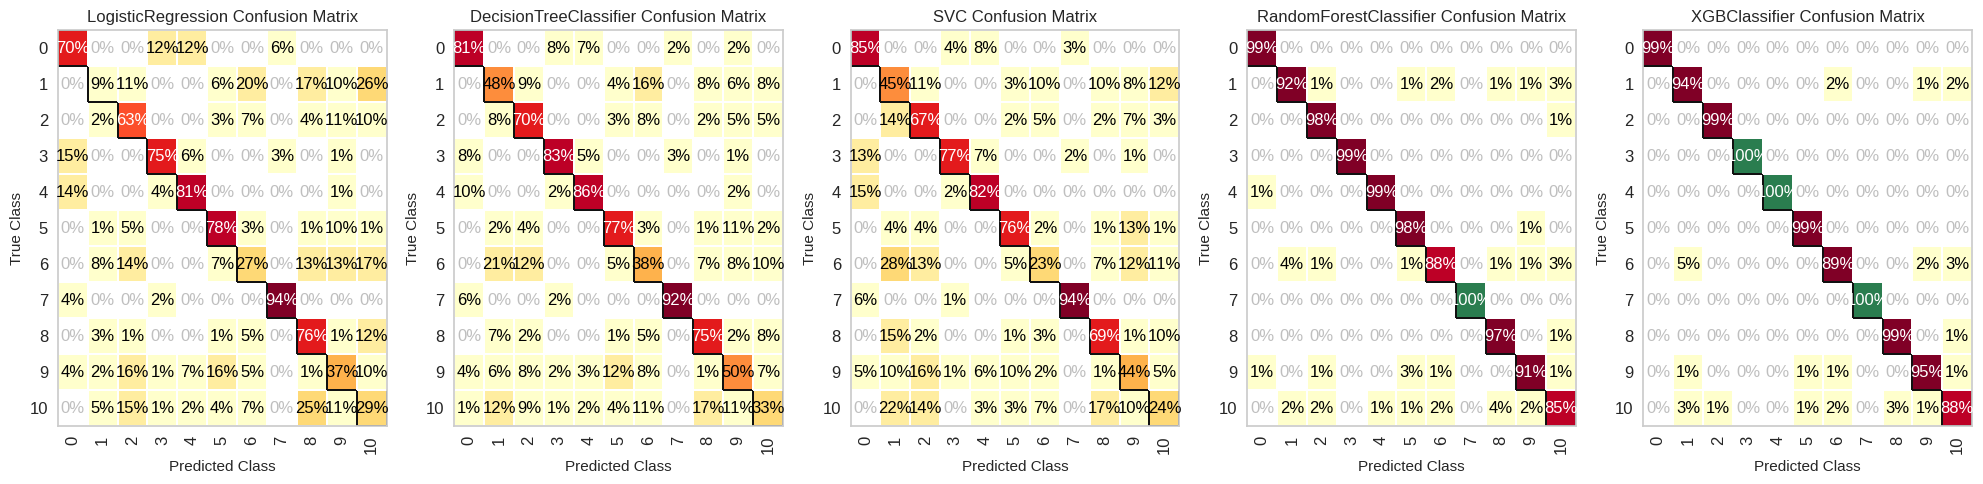

In [ ]:
fig, axe = plt.subplots(ncols=5,nrows=1,figsize=(20, 5))
fig.tight_layout(pad=8.0)
visualgrid = [ConfusionMatrix(classifiers[0], classes=classes, support=True, percent=True, ax=axe[0]),
              ConfusionMatrix(classifiers[1], classes=classes, support=True, percent=True, ax=axe[1]),
              ConfusionMatrix(classifiers[2], classes=classes, support=True, percent=True, ax=axe[2]),
              ConfusionMatrix(classifiers[3], classes=classes, support=True, percent=True, ax=axe[3]),
              ConfusionMatrix(classifiers[4], classes=classes, support=True, percent=True, ax=axe[4]),]
for viz in visualgrid:
  viz.fit(X_train_scaled, y_train)
  viz.score(X_train_scaled, y_train)
  viz.finalize()
fig.show()

### **Test Dataset**

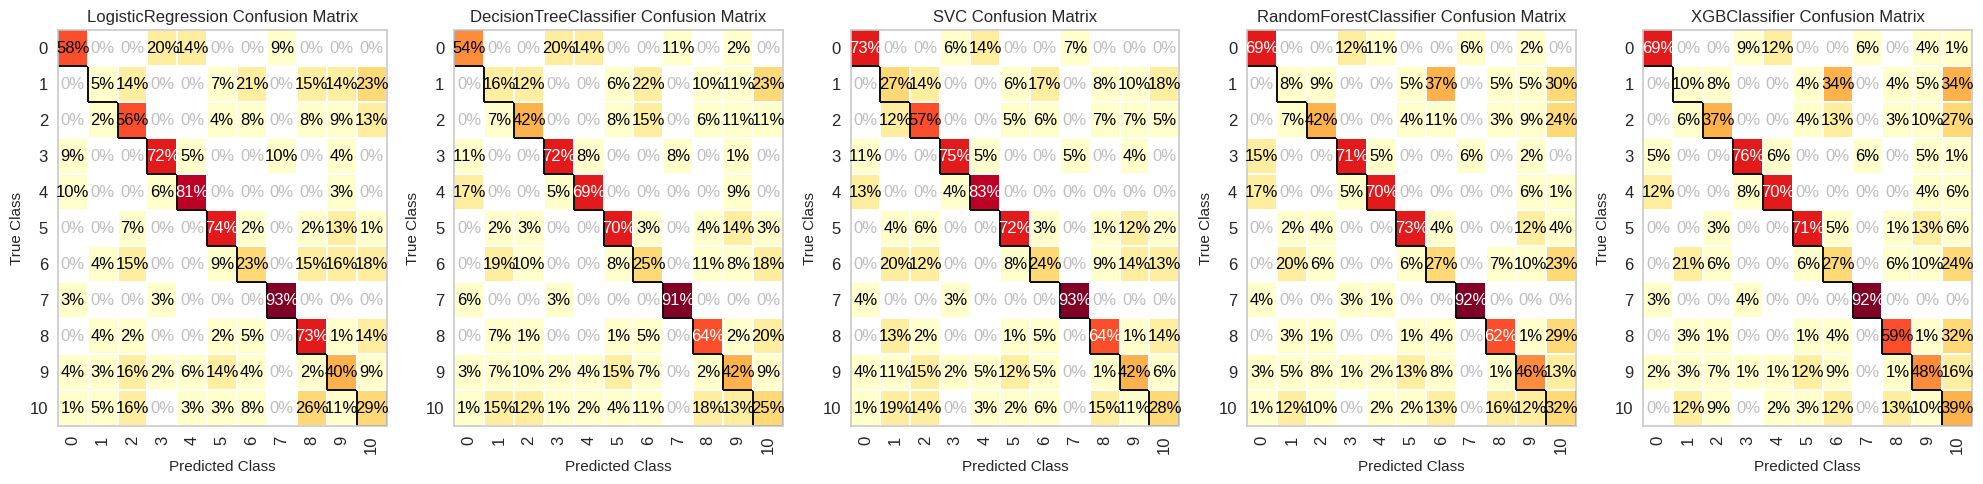

In [ ]:
fig, axe = plt.subplots(ncols=5,nrows=1,figsize=(20, 5))
fig.tight_layout(pad=8.0)
visualgrid = [ConfusionMatrix(classifiers[0], classes=classes, support=True, percent=True, ax=axe[0]),
              ConfusionMatrix(classifiers[1], classes=classes, support=True, percent=True, ax=axe[1]),
              ConfusionMatrix(classifiers[2], classes=classes, support=True, percent=True, ax=axe[2]),
              ConfusionMatrix(classifiers[3], classes=classes, support=True, percent=True, ax=axe[3]),
              ConfusionMatrix(classifiers[4], classes=classes, support=True, percent=True, ax=axe[4])]
for viz in visualgrid:
  viz.fit(X_test_scaled, y_test)
  viz.score(X_test_scaled, y_test)
  viz.finalize()
fig.show()

# Conclusions from the Classification Reports  

 Overall, the Random Forest and XGBoost models show better diagonal dominance (higher true positives), suggesting stronger classification accuracy. In contrast, Logistic Regression and SVC exhibit more off-diagonal dispersion, indicating higher misclassification rates, particularly for certain minority classes.

The Decision Tree model demonstrates moderate performance, with some classes being well-predicted but others showing significant confusion, likely due to overfitting or limited generalization. Meanwhile, the SVC model struggles with class imbalances, as seen by uneven error distributions across the matrix.

Notably, the XGBoost classifier appears to balance precision and recall effectively, with fewer extreme misclassifications compared to other models. However, some classes (e.g., lower-frequency categories) still pose challenges across all classifiers, highlighting potential areas for data rebalancing or feature engineering to improve robustness.

### **ROCAUC**

### **Training Data**

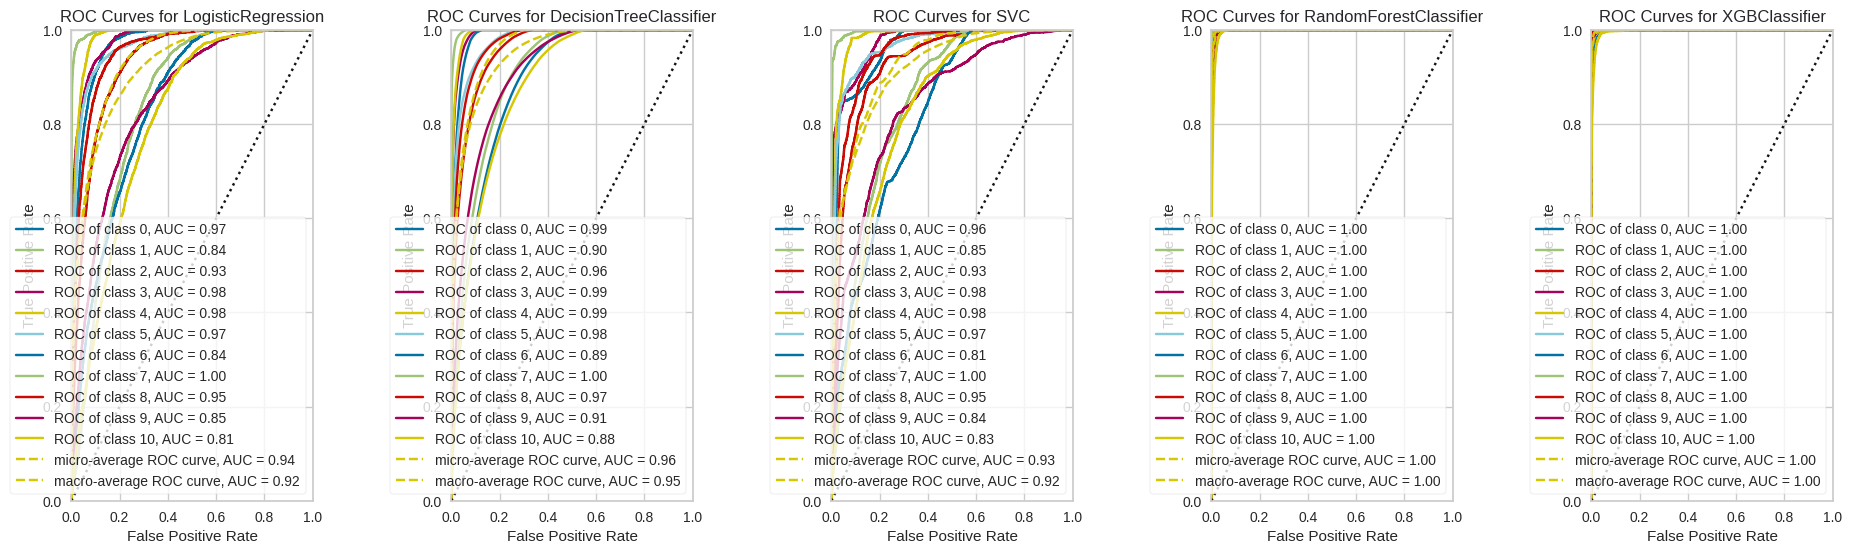

In [ ]:
fig, axe = plt.subplots(ncols=5,figsize=(20, 7))
fig.tight_layout(pad=6.0)

visualgrid = [ROCAUC(classifiers[0], classes=classes, ax=axe[0]),
              ROCAUC(classifiers[1], classes=classes, ax=axe[1]),
              ROCAUC(classifiers[2], classes=classes, ax=axe[2]),
              ROCAUC(classifiers[3], classes=classes, ax=axe[3]),
              ROCAUC(classifiers[4], classes=classes, ax=axe[4]),]

for viz in visualgrid:
  viz.fit(X_train_scaled, y_train)
  viz.score(X_train_scaled, y_train)
  viz.finalize()

plt.show()

### **Test Data**

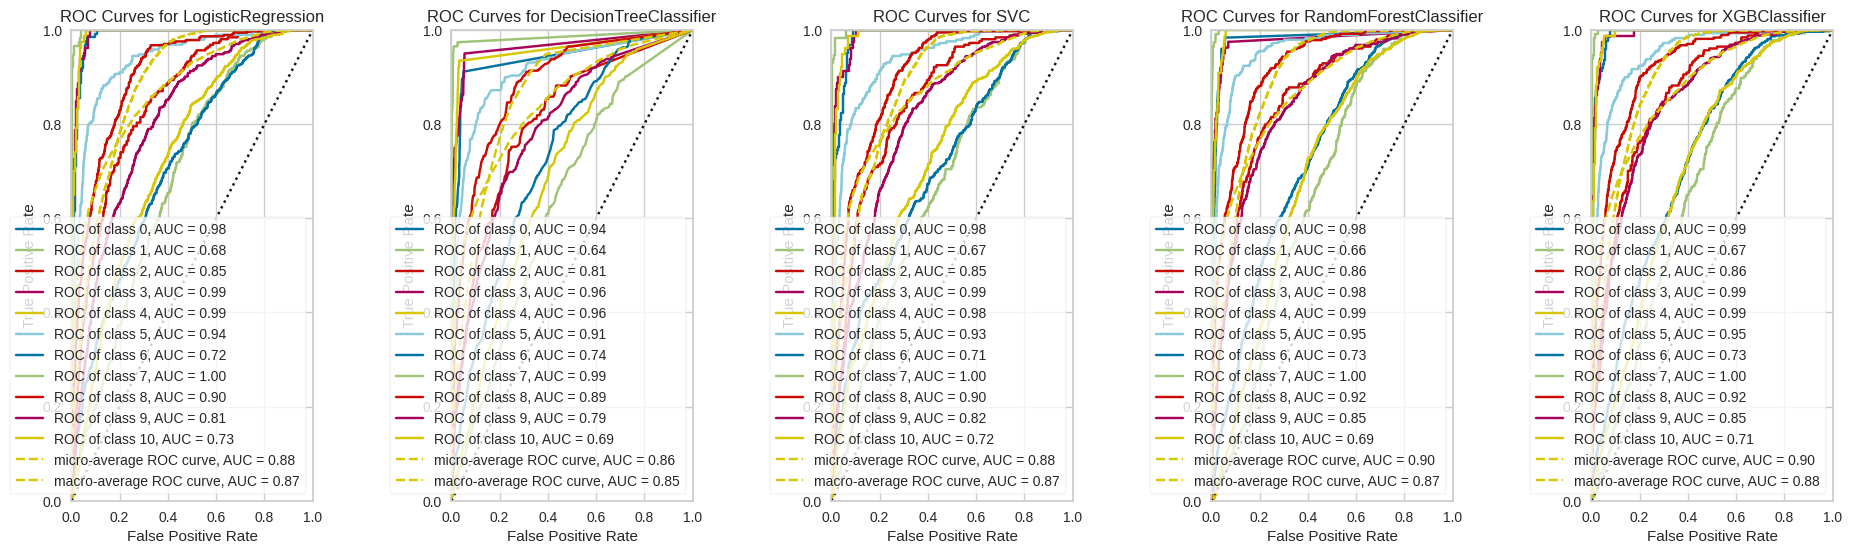

In [ ]:
fig, axe = plt.subplots(ncols=5,figsize=(20, 7))
fig.tight_layout(pad=6.0)

visualgrid = [ROCAUC(classifiers[0], classes=classes, ax=axe[0]),
              ROCAUC(classifiers[1], classes=classes, ax=axe[1]),
              ROCAUC(classifiers[2], classes=classes, ax=axe[2]),
              ROCAUC(classifiers[3], classes=classes, ax=axe[3]),
              ROCAUC(classifiers[4], classes=classes, ax=axe[4]),]

for viz in visualgrid:
  viz.fit(X_test_scaled, y_test)
  viz.score(X_test_scaled, y_test)
  viz.finalize()

plt.show()

# **Conclusions from ROC Analysis**  

The ROC curves reveal that all models—Logistic Regression, SVC, Random Forest, XGBoost, and Decision Tree—exhibit similar discriminative capacity, with closely aligned AUC scores across most categories. This suggests that, on a broad level, their ability to distinguish between classes is comparable. However, the Decision Tree model underperforms relative to the others, consistently scoring lower in nearly every category. This weaker performance may stem from its tendency to overfit or its limited generalization compared to more robust ensemble methods like Random Forest and XGBoost.


In this case we select the XGBOOST model like best candidate to use for predicting music genres, and It will be export to make pipeline.